In [5]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
import pmdarima as pmd
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [6]:
# Extract data from SQLITE for average monthly rent to quick check data
conn = sqlite3.connect('rental.sqlite')
df = pd.read_sql_query('''
                        SELECT
                            DATE((rent_approval_date || '-01')) AS month,
                            ROUND(AVG(monthly_rent)) AS overall
                        FROM rental
                        GROUP BY 1
                        ORDER BY 1
                        ''', conn, parse_dates=True)

df.head(10)

,month,overall
0,2021-01-01,2049.0
1,2021-02-01,2048.0
2,2021-03-01,2068.0
3,2021-04-01,2083.0
4,2021-05-01,2104.0
5,2021-06-01,2121.0
6,2021-07-01,2145.0
7,2021-08-01,2136.0
8,2021-09-01,2128.0
9,2021-10-01,2157.0


<Axes: xlabel='month', ylabel='overall'>

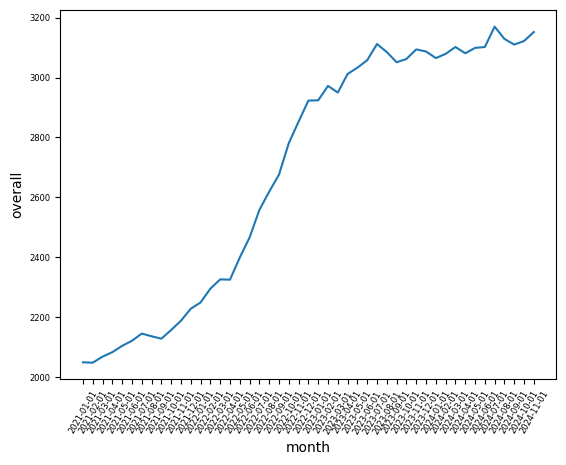

In [7]:
# Plot values to check monthly trend
plt.xticks(rotation=60)
plt.tick_params(labelsize=6)
sns.lineplot(x='month', y='overall', data=df)


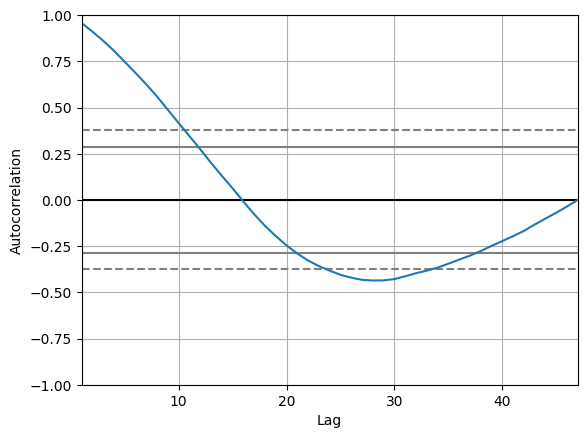

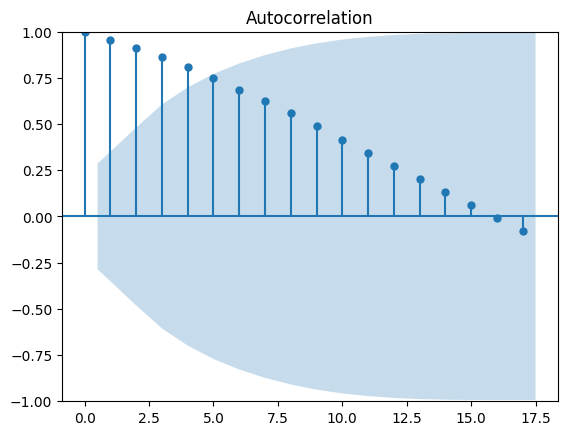

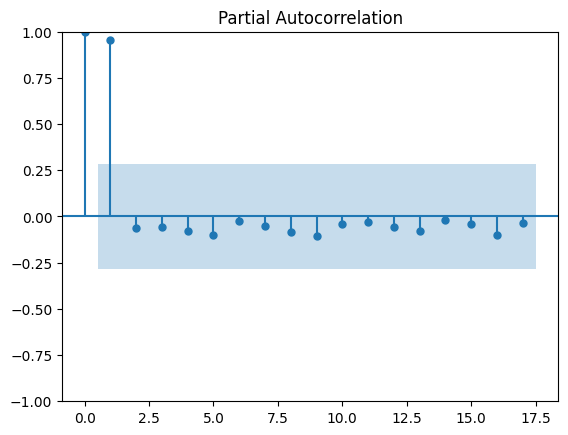

In [8]:
# Check autocorrelation and ideal lag periods
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

data = df['overall']
autocorrelation_plot(data)

plot_acf(data)
plt.show()

plot_pacf(data)
plt.show()

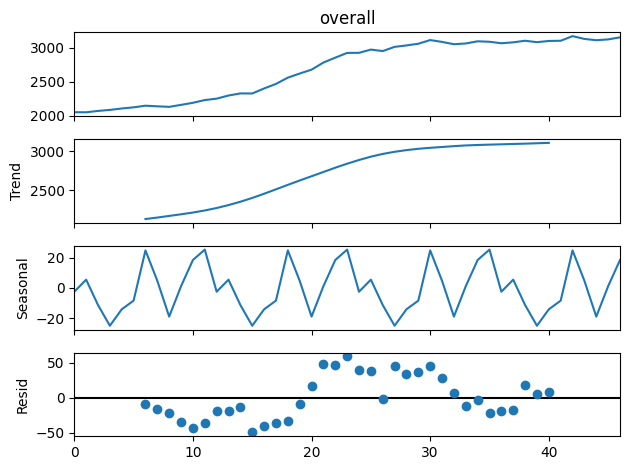

In [9]:
# Decompose data to check trend and seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition=seasonal_decompose(data, model='additive', period=12)
decomposition.plot()
plt.show()

In [10]:
# Perform Dicky-Fuller test to check for stationarity
dftest = adfuller(data, autolag = 'AIC')
print("P-Value : ", dftest[1])
print("Num Of Lags : ", dftest[2])
print("Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])

P-Value :  0.5985869074725192
Num Of Lags :  0
Num Of Observations Used For ADF Regression and Critical Values Calculation : 46


In [11]:
# Perform data differencing by lag periods to achieve significance for stationarity test
data_diff = data.diff(periods=1)
# data_diff = np.log(data)

dftest = adfuller(data_diff.dropna(), autolag = 'AIC')
print("P-Value : ", dftest[1])
print("Num Of Lags : ", dftest[2])
print("Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])


P-Value :  0.04227733388992144
Num Of Lags :  1
Num Of Observations Used For ADF Regression and Critical Values Calculation : 44


In [12]:
# Test model to find best ARIMA model
import warnings
warnings.filterwarnings("ignore")

model = pmd.auto_arima(data, start_p=1, start_q=1, test='adf', m=12, seasonal=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=461.225, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=446.228, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=444.247, Time=0.17 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=443.443, Time=0.05 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=443.733, Time=0.12 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=445.291, Time=0.18 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=445.276, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=450.373, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=447.160, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=445.441, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 2.270 seconds


In [13]:
sarima_test = SARIMAX(data, order=(0,2,1), seasonal_order=(0,0,0,12))
predicted = sarima_test.fit(method='lbfgs').predict()

predicted

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.67744D+00    |proj g|=  8.86303D-03

At iterate    5    f=  4.67509D+00    |proj g|=  8.44642D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     11      1     0     0   9.548D-07   4.675D+00
  F =   4.6749271875077243     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


0        0.000000
1     3073.542883
2     2048.463220
3     2078.765964
4     2095.425357
5     2119.317967
6     2136.843572
7     2163.294786
8     2146.253027
9     2132.929007
10    2168.914334
11    2205.438670
12    2251.960517
13    2272.105280
14    2324.716921
15    2356.087392
16    2346.112120
17    2435.380771
18    2511.220303
19    2616.725085
20    2678.381824
21    2734.694224
22    2853.062059
23    2925.044143
24    2994.454028
25    2975.114954
26    3022.215711
27    2979.368068
28    3050.788440
29    3066.653172
30    3089.155125
31    3149.750113
32    3104.057682
33    3054.740688
34    3067.836348
35    3107.389420
36    3094.503286
37    3063.986110
38    3082.320405
39    3111.001622
40    3081.340583
41    3104.438604
42    3106.734614
43    3192.998426
44    3133.522996
45    3107.732244
46    3123.851141
Name: predicted_mean, dtype: float64

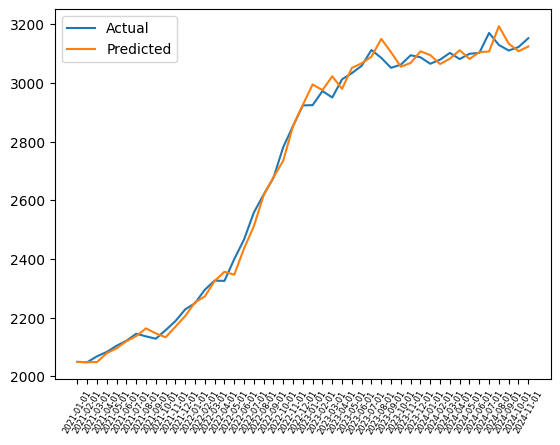

In [14]:
# Check if results of prediction against existing data
predicted[:2] = data[:2]
predicted = predicted.round(2)
df['predicted'] = predicted

plt.plot(df['month'], df['overall'], label='Actual')
plt.plot(df['month'], df['predicted'], label='Predicted')
plt.xticks(rotation=60, fontsize=6)
plt.legend()

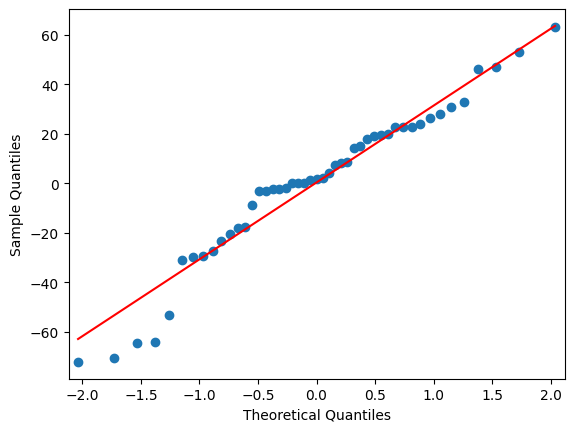

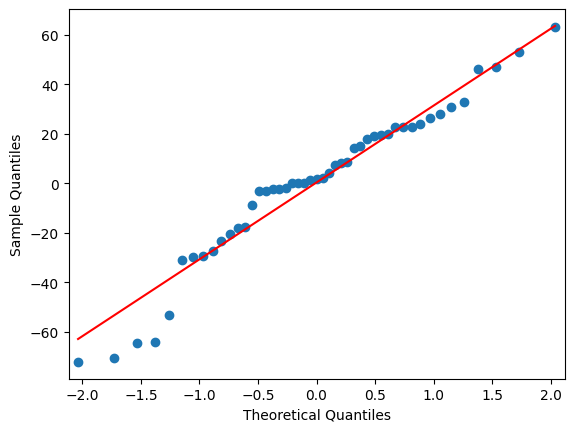

In [15]:
# Check if residuals are normally distributed using QQplot
import statsmodels.api as sm

resid = data-predicted
sm.qqplot(resid, line='s')

In [32]:
# Run prediction model for the next 12 months
pred = model.predict(n_periods=12)
new_rent = pd.concat([predicted, pred]).round(2)

# Update month in dataframe to include "new" months
df['month'] = pd.to_datetime(df['month'])
max_month = max(df['month'])
start = max_month + pd.DateOffset(months=1)
end = max_month + pd.DateOffset(months=12)
new_month = pd.Series(pd.date_range(start, end, freq='MS'))

new_data = pd.DataFrame({
    'month':[nm for nm in new_month],
    'overall':None,
    'predicted':[pr for pr in pred]
    })

final_data = pd.concat([df, new_data], ignore_index=True)

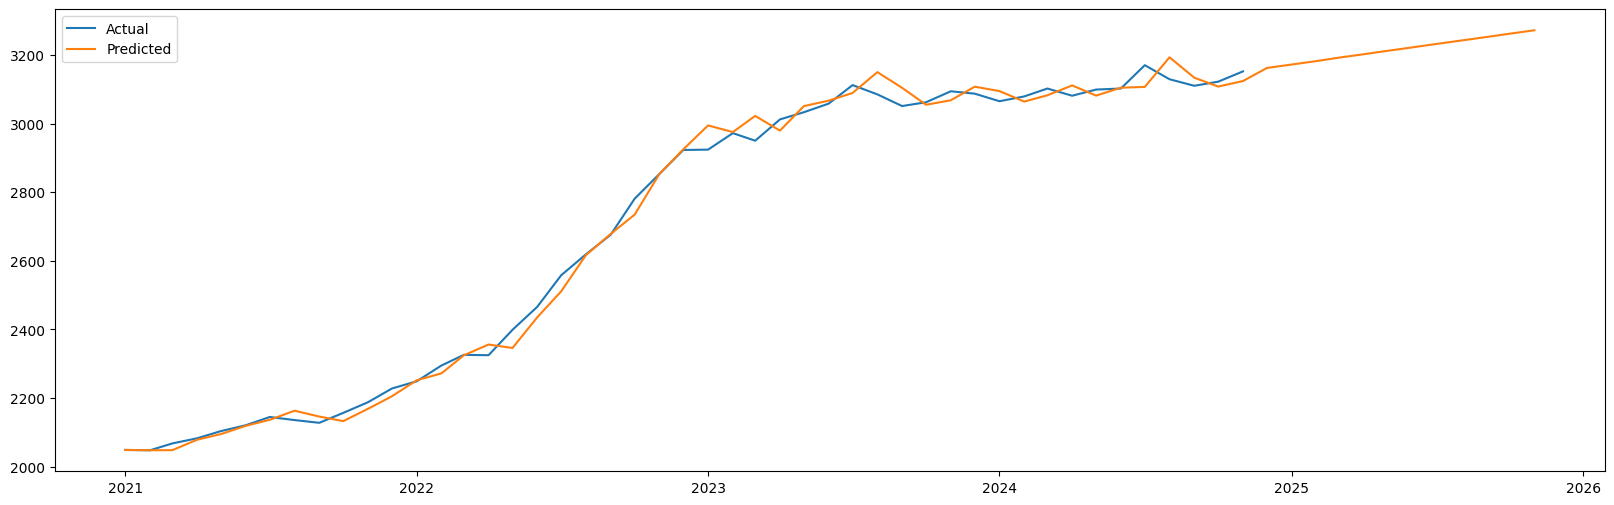

In [42]:
# Combine predicted value for existing months with future 12 month predicted values


plt.figure(figsize=(20,6))
plt.plot(final_data['month'], final_data['overall'], label='Actual')
plt.plot(final_data['month'], final_data['predicted'], label='Predicted')
plt.legend()